✅ Apple Metal GPU Acceleration Enabled!
✅ Mixed Precision Enabled!
✅ Loading data from: /Users/sohammandal/Developer/trading-system/data/historical_stock_data_15min_1year.csv
✅ Scaler saved successfully!
✅ Training Data: (520846, 50, 7), Testing Data: (128109, 50, 7)
✅ LSTM Model Compiled!


2025-02-21 16:14:47.891423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-21 16:14:47.891454: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-21 16:14:47.891459: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-02-21 16:14:47.891488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-21 16:14:47.891503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/sohammandal/Developer/trading-system/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

Epoch 1/50


2025-02-21 16:14:48.957815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2035/2035 ━━━━━━━━━━━━━━━━━━━━ 88s 42ms/step - loss: 0.0038 - val_loss: 4.6354e-04 - learning_rate: 0.0010
Epoch 2/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 86s 42ms/step - loss: 0.0030 - val_loss: 6.0157e-04 - learning_rate: 0.0010
Epoch 3/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 85s 42ms/step - loss: 0.0020 - val_loss: 3.7923e-04 - learning_rate: 0.0010
Epoch 4/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0033
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - loss: 0.0033 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - loss: 0.0026 - val_loss: 3.1216e-04 - learning_rate: 5.0000e-04
Epoch 6/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - loss: 0.0012 - val_loss: 3.8399e-04 - learning_rate: 5.0000e-04
Epoch 7/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - loss: 0.0018 - val_loss: 7.1619e-04 - learning_rate: 5.0000e-04
Epoch 8/50
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 

✅ LSTM Model Saved!
16277/16277 ━━━━━━━━━━━━━━━━━━━━ 147s 9ms/step - loss: 1.0925e-04
4004/4004 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 3.3083e-04
📊 Train Loss: 0.0001, Test Loss: 0.0003
4004/4004 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step
📊 **Test RMSE:** $17.30


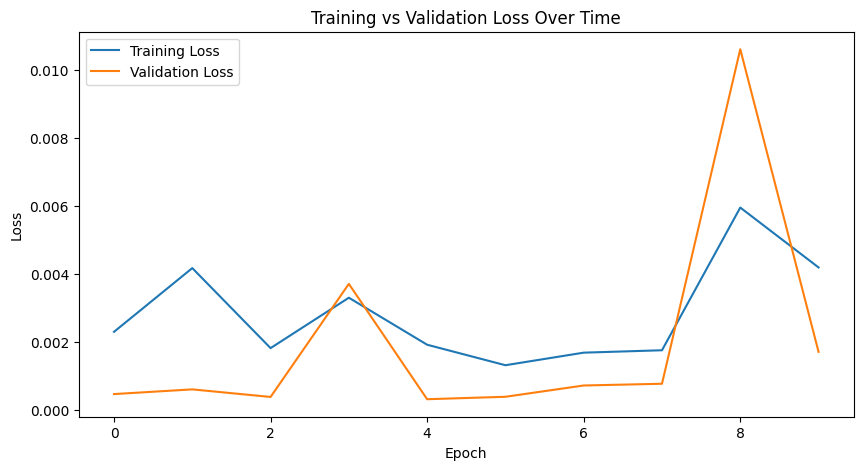

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

# ✅ Enable Apple GPU Acceleration
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
try:
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)
    print("✅ Apple Metal GPU Acceleration Enabled!")
except:
    print("⚠️ No GPU detected, running on CPU.")

# ✅ Enable Mixed Precision for Faster Training
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)
print("✅ Mixed Precision Enabled!")

# 📂 Load Data
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(project_root, "data", "historical_stock_data_15min_1year.csv")

if not os.path.exists(data_path):
    raise FileNotFoundError(f"❌ Error: {data_path} not found. Ensure fetch script has been run.")

print(f"✅ Loading data from: {data_path}")
df = pd.read_csv(data_path)

# 🕒 Ensure proper datetime format & sorting
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by=["symbol", "timestamp"]).reset_index(drop=True)

# 🎯 Define Features & Target
features = ["open", "high", "low", "close", "volume", "trade_count", "vwap"]
target = "close"

# ✅ **Split Train/Test Per Symbol to Prevent Leakage**
train_dfs, test_dfs = [], []
for symbol in df["symbol"].unique():
    symbol_df = df[df["symbol"] == symbol].sort_values("timestamp")

    if len(symbol_df) < 51:  # Ensure enough data for sequences
        continue  # Skip symbols with insufficient data

    split_idx = int(0.8 * len(symbol_df))  # 80% train, 20% test

    train_dfs.append(symbol_df.iloc[:split_idx])
    test_dfs.append(symbol_df.iloc[split_idx:])

# ✅ **Fit Scaler on Training Data ONLY**
all_train_df = pd.concat(train_dfs)  # Combine all training data
scaler = MinMaxScaler().fit(all_train_df[features])  # Fit only on training data

# ✅ **Scale Train/Test Data**
for i in range(len(train_dfs)):
    train_dfs[i].loc[:, features] = scaler.transform(train_dfs[i][features])
    test_dfs[i].loc[:, features] = scaler.transform(test_dfs[i][features])


# 💾 **Save Scaler for Later Inverse Transformation**
scaler_path = os.path.join(project_root, "models", "lstm_scaler.pkl")
joblib.dump(scaler, scaler_path)
print("✅ Scaler saved successfully!")

# 🏋️ **Convert Data to LSTM-Friendly Format**
def create_sequences(data, target_col, seq_length=50):
    """
    Convert dataframe into sequences for LSTM training.
    """
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i : i + seq_length][features].values)
        labels.append(data.iloc[i + seq_length][target_col])
    return np.array(sequences), np.array(labels)

# ✅ **Generate Sequences Per Stock Symbol**
sequence_length = 50  # Using last 50 timesteps for prediction
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(len(train_dfs)):
    train_X, train_y = create_sequences(train_dfs[i], target)

    # **Handle short test sequences (Edge Case Fix)**
    if len(test_dfs[i]) >= sequence_length + 1:
        test_X, test_y = create_sequences(test_dfs[i], target)
        X_test.append(test_X)
        y_test.append(test_y)

    X_train.append(train_X)
    y_train.append(train_y)

# ✅ **Combine All Stocks into a Single Dataset**
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

if X_test:  # Ensure test data exists
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)
else:
    raise ValueError("❌ No valid test sequences available. Check train/test split.")

print(f"✅ Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# 🏗️ **Build Optimized LSTM Model**
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features)), 
         activation="tanh", recurrent_activation="sigmoid", use_bias=True, 
         kernel_initializer="glorot_uniform", recurrent_initializer="orthogonal"),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="tanh"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, dtype=tf.float32)  # **Force 32-bit float output**
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
print("✅ LSTM Model Compiled!")

# 🛑 **Prevent Overfitting with Callbacks**
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# 🚀 **Train Model**
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=256,  # **Optimized batch size for M1**
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 💾 **Save Model**
os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
model.save(os.path.join(project_root, "models", "lstm_model.h5"))
print("✅ LSTM Model Saved!")

# 🔎 **Evaluate Model**
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f"📊 Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# 🔄 **Inverse Transform Predictions Back to Original Scale**
y_pred = model.predict(X_test)

# ✅ Convert back to original price scale
close_min = scaler.data_min_[features.index("close")]
close_max = scaler.data_max_[features.index("close")]

y_test_actual = y_test * (close_max - close_min) + close_min
y_pred_actual = y_pred.astype(np.float32) * (close_max - close_min) + close_min  # **Fixed Data Type Issue**

# 🛠️ **Report MSE in Actual Price Scale**
test_mse = mean_squared_error(y_test_actual, y_pred_actual)
test_rmse = np.sqrt(test_mse)
print(f"📊 **Test RMSE:** ${test_rmse:.2f}")

# 📈 **Plot Training & Validation Loss**
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss Over Time")
plt.show()
